In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/historical-e-commerce-data/data.csv


# 1. Introduction

Short-term sales forecasting plays a critical role in staffing, and diviation analysis between expected and actual outcomes in e-commerce businesses. 

Considering that hourly sales are extremely noisy, this project focuses on **predicting next-day total sales** using historical transaction data from an actual historical e-commerce dataset of the company from 2010.12 to 2011.12. 

Dataset source: Kaggle – E-Commerce Data https://www.kaggle.com/datasets/carrie1/ecommerce-data.

Rather than decomposing sales into quantity and price components, this study treats total sales as the forecasting target and models its temporal dynamics **using lagged sales values and calendar-based features**.

Since over 90% of transactions originate from the United Kingdom, the analysis deliberately concentrates on the UK market to ensure model stability, and practical relevance.

# 2. Data Preparation

2.1 inputting the data

In [2]:
import pandas as pd
df_file_path = "/kaggle/input/historical-e-commerce-data/data.csv"
df = pd.read_csv(df_file_path, encoding="latin")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The dataset contains 541909 rows and 8 columns.

Although "Description" and "CustomerID" have missing values, considering that predicting next-hour total sales only uses lagged sales values and calendar-based features, it makes no sense to deal with them.

## 2.2 Excluding the data of other countries

In [3]:
(df["Country"].value_counts() / df["Country"].value_counts().sum()).head()

Country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: count, dtype: float64

Since over 90% of transactions originate from the United Kingdom, the analysis deliberately concentrates on the UK market and we will exclude the data of other countries.

In [4]:
df_UK = df.loc[df["Country"] == "United Kingdom"].copy()

## 2.3 Feature engineering

In [5]:
df_UK["Sale"] = df_UK["Quantity"] * df_UK["UnitPrice"]
df_UK["InvoiceDate"] = pd.to_datetime(df_UK["InvoiceDate"])
df_UK["Date"] = df_UK["InvoiceDate"].dt.date
df_UK_date = (df_UK.groupby("Date", as_index=False).Sale.sum())
df_UK_date = df_UK_date.set_index("Date")

Text(0, 0.5, 'Total Sales')

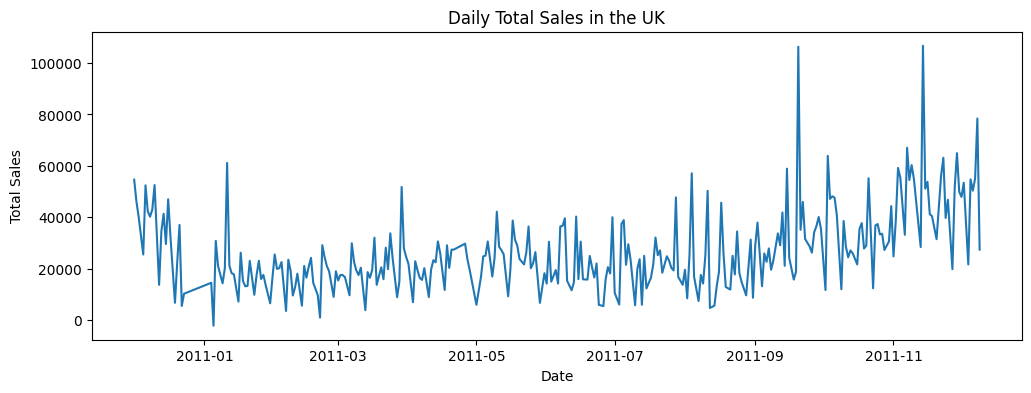

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df_UK_date.index, df_UK_date["Sale"])
plt.title("Daily Total Sales in the UK")
plt.xlabel("Date")
plt.ylabel("Total Sales")

The daily sales series exhibits substantial volatility and short-term dependence, motivating the use of lagged sales features for forecasting.

In [7]:
df_UK_date.head(10)

,Sale
Date,
2010-12-01,54615.15
2010-12-02,46053.93
2010-12-03,39985.44
2010-12-05,25462.20
2010-12-06,52402.84
2010-12-07,42301.48
2010-12-08,40167.17
2010-12-09,42994.03
2010-12-10,52504.60


Apparently the date of "InvoiceDate" is not continuous, we should add the missing dates.

In [8]:
full_date = pd.date_range(start=df_UK_date.index.min(), end=df_UK_date.index.max(), freq="d")
df_UK_date = df_UK_date.reindex(full_date)
df_UK_date.index.name = "Date"

To predict next-day total sales which  is our target, the model uses the following features:

- Calendar features (day of week, month)
- Lagged sales values (yesterday and same day of the previous week)

In [9]:
df_UK_date["Dayofweek"] = df_UK_date.index.dayofweek
df_UK_date["Month"] = df_UK_date.index.month
df_UK_date["Sale_lag1"] = df_UK_date["Sale"].shift(1)
df_UK_date["Sale_lag7"] = df_UK_date["Sale"].shift(7)
df_UK_date["Sale_tar"] = df_UK_date["Sale"].shift(-1)

Considering that the columns of the key features we added have NaN values, we should deal with them.


In [10]:
df_UK_date = df_UK_date.dropna()
df_UK_date.shape

(187, 6)

Due to aggregation at the daily level and the limited time span (approximately one year from 2010.12 to 2011.12), the effective sample size is relatively small (187 observations), which may constrain the model’s ability to generalize. However, this setup reflects a realistic business scenario where only recent historical data is available for short-term operational forecasting, because the dataset for this analysis is from an actual company.

# 3. Model training

## 3.1 Feature Set and Target Definition

In [11]:
features = ["Dayofweek", "Month", "Sale_lag1", "Sale_lag7"]
X = df_UK_date[features]
y = df_UK_date["Sale_tar"]

##  3.2 Train–Validation Split

Considering what we want to predict the next-day total sales, it is reasonable to split  the dataset chronologically rather than randomly.

In [12]:
split_index = int(len(df_UK_date) * 0.8)
train_X = X.iloc[:split_index]
train_y = y.iloc[:split_index]
val_X = X.iloc[split_index:]
val_y = y.iloc[split_index:]

##  3.3 Model Selection

In practice, the most recent available daily sales data is yesterday’s sales, as today’s full sales are not yet observed at the time of forecasting. Therefore, as a naive baseline, we predict tomorrow’s sales using yesterday’s sales without applying any statistical or machine learning model.

In [13]:
# Baseline(NoModel)
from sklearn.metrics import mean_absolute_error
pred_y = df_UK_date["Sale_lag1"].iloc[split_index:]
mae_b = mean_absolute_error(val_y, pred_y)
ration_mae_b = (mae_b / (df_UK_date["Sale_tar"].iloc[split_index:].median()))
print("ratio of Baseline's MAE to the median sale value:", ration_mae_b)

ratio of Baseline's MAE to the median sale value: 0.324885248993946


In [14]:
# LinearModel
from sklearn.linear_model import LinearRegression
model_l = LinearRegression()
model_l.fit(train_X, train_y)
pred_y = model_l.predict(val_X)
mae_l = mean_absolute_error(val_y, pred_y)
ration_mae_l = (mae_l / (df_UK_date["Sale_tar"].iloc[split_index:].median()))
print("ratio of LinearModel's MAE to the median sale value:", ration_mae_l)

ratio of LinearModel's MAE to the median sale value: 0.27043753150359684


In [15]:
# RandomForestModel
from sklearn.ensemble import RandomForestRegressor
model_r = RandomForestRegressor(n_estimators=100, random_state=1)
model_r.fit(train_X, train_y)
pred_y_r = model_r.predict(val_X)
mae_r = mean_absolute_error(val_y, pred_y_r)
ration_mae_r = (mae_r / (df_UK_date["Sale_tar"].iloc[split_index:].median()))
print("ratio of RandomForestModel's MAE to the median sale value", ration_mae_r)

ratio of RandomForestModel's MAE to the median sale value 0.2458423473531953


Baseline and Model performance is evaluated using MAE, which provides an intuitive measure of forecast accuracy in sales units. According to the ratio of MAE to the median sale value, using model is more effiective than not using model and RandomForestModel's MAE is samller than LinearModel, motivating the use of a Random Forest model.


Text(0.5, 1.0, 'Actual vs Predicted Sales (RandomForestModel)')

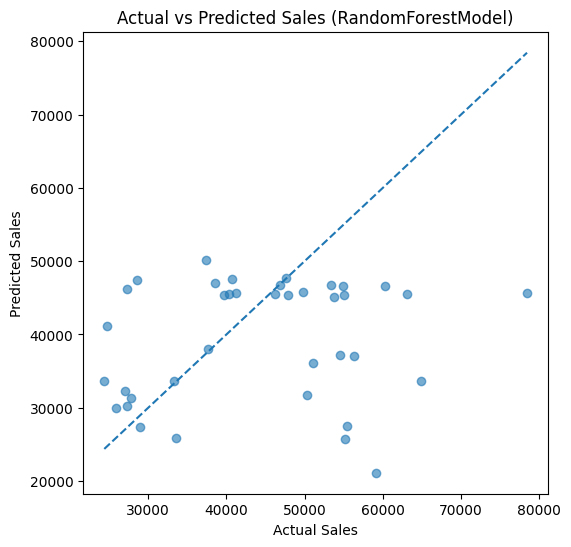

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(val_y, pred_y_r, alpha=0.6)
plt.plot([val_y.min(), val_y.max()],
         [val_y.min(), val_y.max()],
         linestyle="--")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (RandomForestModel)")

This pattern indicates that the RandomForestModel captures average sale levels reasonably well, but struggles to predict extreme high-sales days. 
Such behavior is expected given the limited sample size and the absence of explicit promotion or event-related features.

# 4. Feature Importance Analysis

In [17]:
importances = model_r.feature_importances_
feature_importance_df = pd.DataFrame({"features":X.columns, "importance":importances}).sort_values(by="importance", ascending=False)
feature_importance_df

,features,importance
2,Sale_lag1,0.365779
1,Month,0.327928
3,Sale_lag7,0.222820
0,Dayofweek,0.083474


Feature importance analysis shows that the sale of yesterday is the most influential feature, accounting for approximately 37% of the total importance. Month of calendar features is the second most important feature, and the third is the sale of the day before a week, while time-related variable dayofweek contributes very little to the model’s predictions.

# 5. Business Insights and Implications

- Recent sales levels such as yesterday and the same day of the previous week exhibit strong predictive power, indicating short-term demand persistence, which can be extended to the adjustment of staffing, promotion and so on. In other words, the model suggests that **daily operational planning can be updated on a rolling basis using the most recent sales data, reducing the need for complex long-horizon forecasts**.
- Calendar effect of month is the second influential feature in predicting next-day total sales means **there are monthly sales patterns in the transactions of UK**, which the company should pay attention to. On the contrary, it seems to be unconspicuous to weekly sales patterns.

# 6. Limitations and Future Work

This analysis focuses exclusively on the UK market and uses aggregate daily sales as the forecasting target.

Future extensions may include:
- Country-specific or product-category-level forecasting
- Incorporation of promotion or pricing signals
- Probabilistic forecasting to quantify uncertainty